In [99]:
%load_ext autoreload
%autoreload 2

# Import own packages
# sys.path.append("/mnt/d/Projects/Navigation/MyCode/sydr")
import sys
sys.path.append("/mnt/c/Users/vmangr/Documents/Code/sydr")
from sydr.utils.constants import GPS_L1CA_CODE_FREQ 

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from plot import plotCorrelation, plotSignals
from misc import *
from axcoperations import loadd

import evoapproxlib as eal
from axcoperations import correlate, mult

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create a GNSS signal

In [100]:
# Parameters
prn = 1
samplingFrequency = 5e6
cn0_target = 60
signal_bw = GPS_L1CA_CODE_FREQ # Bandwidth of the signal for CN0 to SNR computation
quantization_bits = 8

# Generate signals
# Original PRN
signal = generateGPSL1CA(prn=prn, samplingFrequency=samplingFrequency)

# Noisy signal
sigma_noise = getSigmaFromCN0(signal_power_dB=0, cn0_target_dB=cn0_target, signal_bw=signal_bw)
signal_noisy = addWhiteNoise(signal, sigma=sigma_noise)

# Quantized signal 
signal_quantized, scale_factor = quantize(signal_noisy, quantization_bits)
#signal_quantized[signal_quantized == 0] = 1

# signal[signal == -1] = -(2**quantization_bits) // 2 + 1
# signal[signal == 1] = (2**quantization_bits) // 2 - 1 
print(GPS_L1CA_CODE_FREQ)


1023000.0


21.733399542559347
24.259189807409587
21.739446403268936


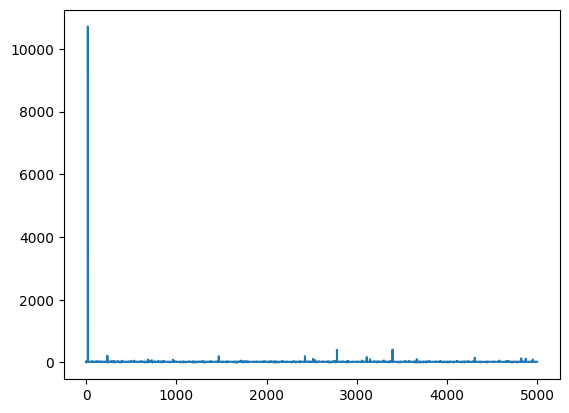

In [101]:
plt.plot(signal_quantized / signal_noisy)
print(np.median(signal_quantized / signal_noisy))
print(np.mean(signal_quantized / signal_noisy))
print(scale_factor)

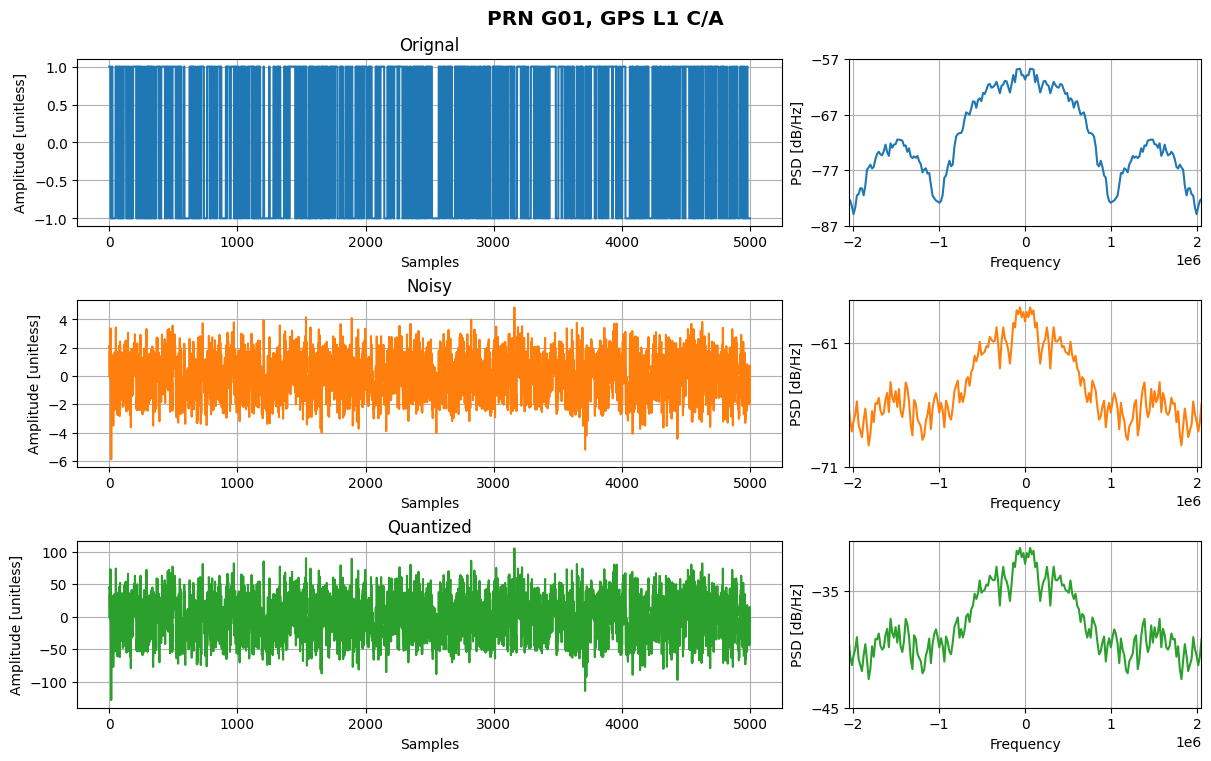

In [102]:
plotSignals({'Orignal' : signal, 'Noisy': signal_noisy, 'Quantized': signal_quantized},
            samplingFrequency, GPS_L1CA_CODE_FREQ, f"PRN G{prn:02d}, GPS L1 C/A")

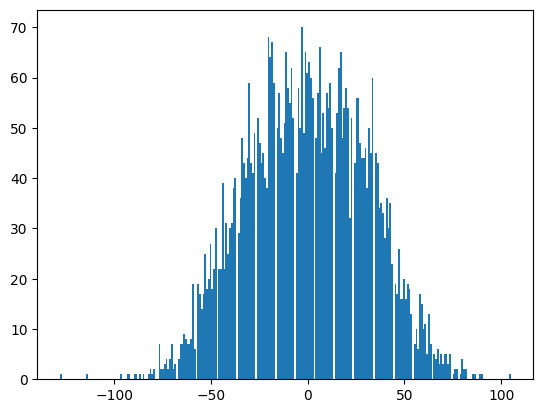

In [103]:
_ = plt.hist(signal_quantized, 2**quantization_bits)

In [104]:
print(np.unique(signal_quantized))

[-128 -114  -97  -93  -92  -89  -88  -87  -85  -82  -81  -80  -79  -77
  -76  -75  -74  -73  -72  -71  -70  -69  -68  -67  -66  -65  -64  -63
  -62  -61  -60  -59  -58  -57  -56  -55  -54  -53  -52  -51  -50  -49
  -48  -47  -46  -45  -44  -43  -42  -41  -40  -39  -38  -37  -36  -35
  -34  -33  -32  -31  -30  -29  -28  -27  -26  -25  -24  -23  -22  -21
  -20  -19  -18  -17  -16  -15  -14  -13  -12  -11  -10   -9   -8   -7
   -6   -5   -4   -3   -2   -1    0    1    2    3    4    5    6    7
    8    9   10   11   12   13   14   15   16   17   18   19   20   21
   22   23   24   25   26   27   28   29   30   31   32   33   34   35
   36   37   38   39   40   41   42   43   44   45   46   47   48   49
   50   51   52   53   54   55   56   57   58   59   60   61   62   63
   64   65   66   67   68   69   70   71   72   73   74   75   76   77
   79   80   81   82   85   86   89   90  105]


### Perform correlation

In [105]:
# Correlate
signal_corr, signal_lags = correlate(signal, signal)
signal_noisy_corr, signal_noisy_lags = correlate(signal, signal_noisy)

In [106]:
signal_quantized_corr, signal_quantized_lags = correlate(signal, signal_quantized)

In [107]:
def correlate(array1, array2, axc_mult=None, axc_correction=0):

    N = len(array1)

    if axc_mult==None:
        corr = sp.signal.correlate(array1, array2, mode='full')
        lags = sp.signal.correlation_lags(len(array1), len(array2), mode="full")
        return corr, lags

    corr = np.zeros(2*N-1)
    lags = np.zeros(2*N-1)
    idx = 0
    for lag in range(-N+1, N):
        correlation = 0
        for i in range(0, N):
            j = i + lag
            if j >= 0 and j < N:
                correlation += axc_mult(array1[j], array2[i]) + axc_correction
        #correlation -= i * 10
        corr[idx] = correlation
        lags[idx] = lag
        idx += 1
    return corr, lags

#signal_axc_corr, signal_axc_lags = correlation(signal, signal_quantized, axc_mult=mult)
#signal_axc_corr, signal_axc_lags = correlate(signal, signal_quantized, axc_mult=eal.mul8s_1KVA.calc)
signal_axc_corr, signal_axc_lags = correlate(signal, signal_quantized, axc_mult=eal.mul8s_1KR3.calc, axc_correction=-16)

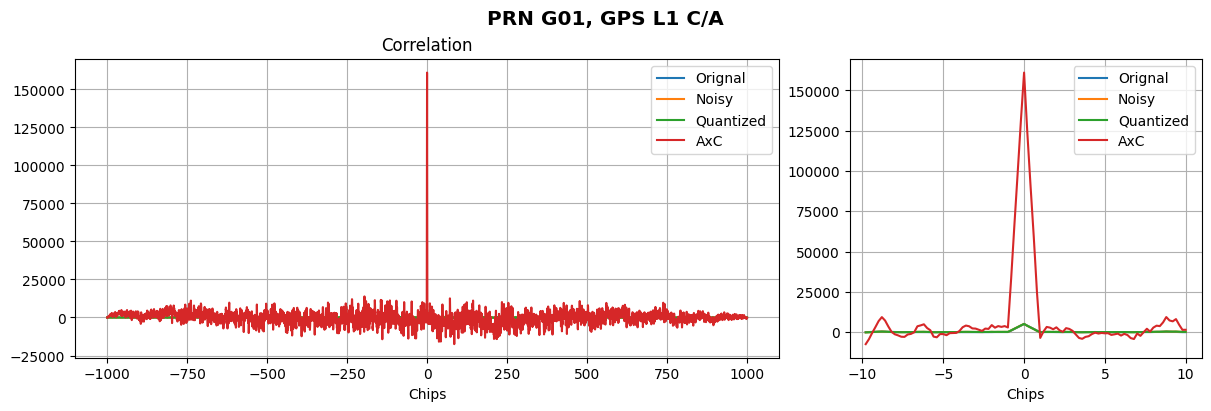

In [108]:
from plot import plotCorrelation
plotCorrelation({
'Orignal' : (signal_corr, signal_lags), 
'Noisy': (signal_noisy_corr, signal_noisy_lags),
'Quantized': (signal_quantized_corr / scale_factor, signal_quantized_lags),
'AxC': (signal_axc_corr / scale_factor, signal_axc_lags)}, 
samplingFrequency, GPS_L1CA_CODE_FREQ, f"PRN G{prn:02d}, GPS L1 C/A")

In [109]:
# Find SNR loss
snr_signal_original = getPostCorrelationSNR(signal_corr, samplingFrequency)
snr_signal_noisy = getPostCorrelationSNR(signal_noisy_corr, samplingFrequency)
snr_signal_quantized = getPostCorrelationSNR(signal_quantized_corr, samplingFrequency)
snr_signal_axc = getPostCorrelationSNR(signal_axc_corr, samplingFrequency)

print(f"Original : {snr_signal_original:.5f}") 
print(f"Noisy    : {snr_signal_noisy:.5f}") 
print(f"Quantized: {snr_signal_quantized:.5f}") 
print(f"AxC      : {snr_signal_axc:.5f}") 

Original : 6.99810
Noisy    : 7.01083
Quantized: 7.01091
AxC      : 7.02106


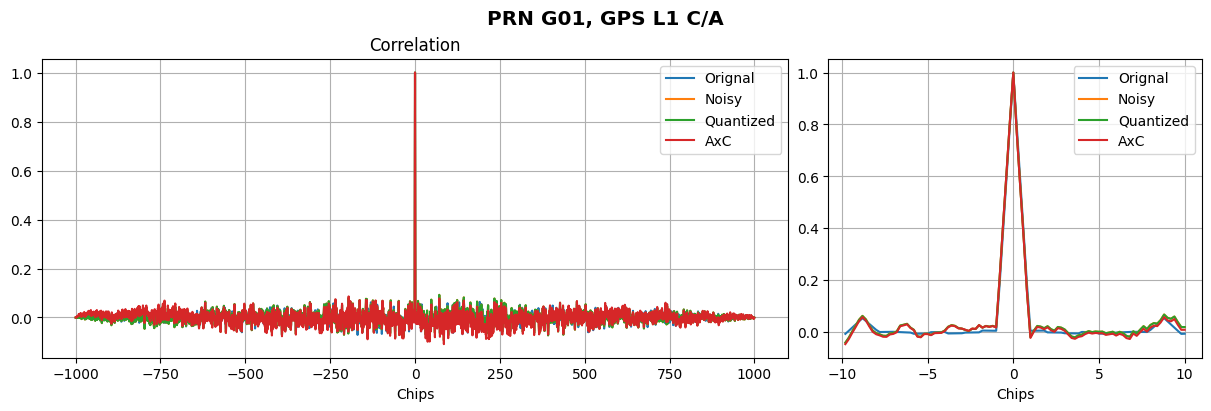

In [110]:
from plot import plotCorrelation
plotCorrelation({
'Orignal' : (signal_corr / np.max(signal_corr), signal_lags), 
'Noisy': (signal_noisy_corr / np.max(signal_noisy_corr), signal_noisy_lags),
'Quantized': (signal_quantized_corr / np.max(signal_quantized_corr), signal_quantized_lags),
'AxC': (signal_axc_corr / np.max(signal_axc_corr), signal_axc_lags)}, 
samplingFrequency, GPS_L1CA_CODE_FREQ, f"PRN G{prn:02d}, GPS L1 C/A")

# MISC

## 8x8 signed

In [151]:
import ealwrapper as ealw

df = ealw.getMultipliersEAL('8x8_signed')


In [152]:
df = df.sort_values(by=['PDK45_PWR'], ascending=False)
df

,NAME,MAE_PERCENT,MAE,WCE_PERCENT,WCE,WCRE_PERCENT,EP_PERCENT,MRE_PERCENT,MSE,PDK45_PWR,PDK45_AREA,PDK45_DELAY
3,mul8s_1KV8,0.0000,0.0,0.0000,0.0,0.0,0.00,0.00,0.0,0.425,729.8,1.48
6,mul8s_1KVA,0.0018,1.2,0.0076,5.0,500.0,50.00,0.28,3.8,0.422,711.0,1.48
7,mul8s_1KVB,0.0064,4.2,0.0260,17.0,1700.0,68.75,0.90,34.0,0.410,685.2,1.47
12,mul8s_1KX2,0.0190,12.0,0.0750,49.0,4900.0,81.25,2.53,248.0,0.391,641.1,1.51
1,mul8s_1KR8,0.0490,32.0,0.2000,128.0,100.0,49.80,2.40,2731.0,0.369,652.8,1.37
5,mul8s_1KR6,0.0510,33.0,0.2100,137.0,900.0,74.80,2.73,2746.0,0.363,635.0,1.37
10,mul8s_1KRC,0.0560,36.0,0.2500,161.0,3300.0,84.18,3.64,2872.0,0.351,599.8,1.36
4,mul8s_1L2H,0.0810,53.0,0.3900,255.0,300.0,74.61,4.41,5462.0,0.301,558.9,1.36
11,mul8s_1KVL,0.1500,101.0,0.6900,449.0,6500.0,91.89,8.93,19690.0,0.289,543.0,1.33
2,mul8s_1KTY,0.3400,224.0,1.3700,896.0,700.0,87.16,15.72,95576.0,0.237,482.4,1.19


Text(0.5, 1.0, '8x8 signed')

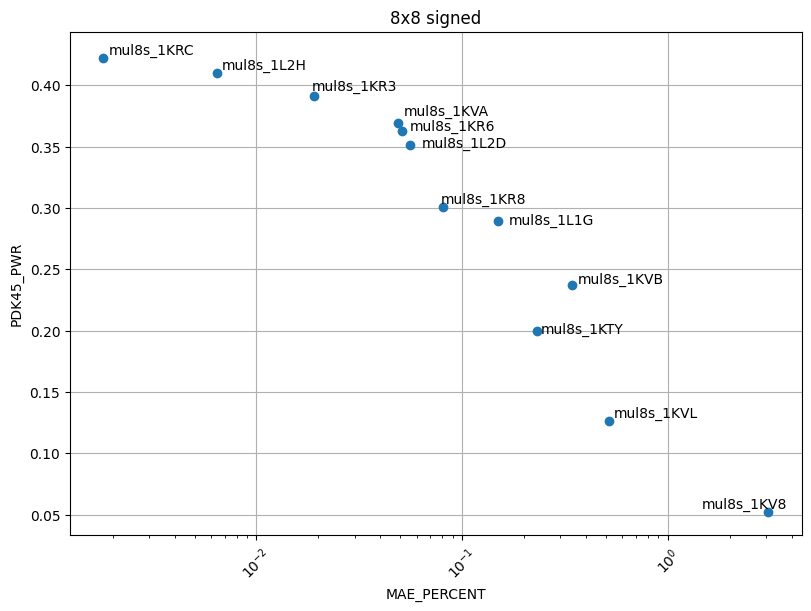

In [153]:
ealw.plotKPI(df, 'MAE_PERCENT', 'PDK45_PWR', log_x=True)
plt.title("8x8 signed")

mul8s_1KR3 -15.75 0.0
mul8s_1KR8 -0.25 0.0
mul8s_1KTY -1.75 0.0
mul8s_1KV8 0.0 0.0
mul8s_1L2H -32256.75 -193.0
mul8s_1KR6 2.25 2.0
mul8s_1KVA 1.25 0.5
mul8s_1KVB 4.25 4.0
mul8s_1L1G -30735.75 -840.0
mul8s_1L2D -31747.75 -435.0
mul8s_1KRC 8.25 8.0
mul8s_1KVL 16.25 16.0
mul8s_1KX2 12.25 12.0


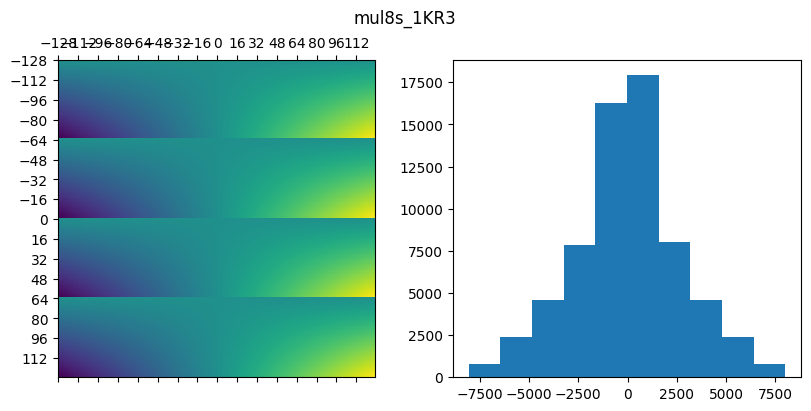

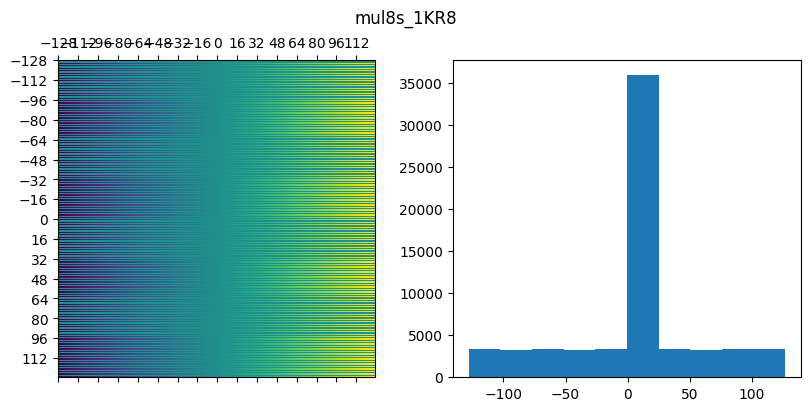

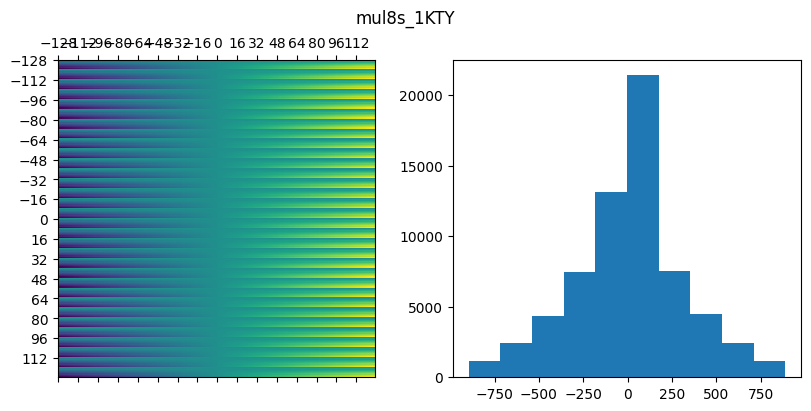

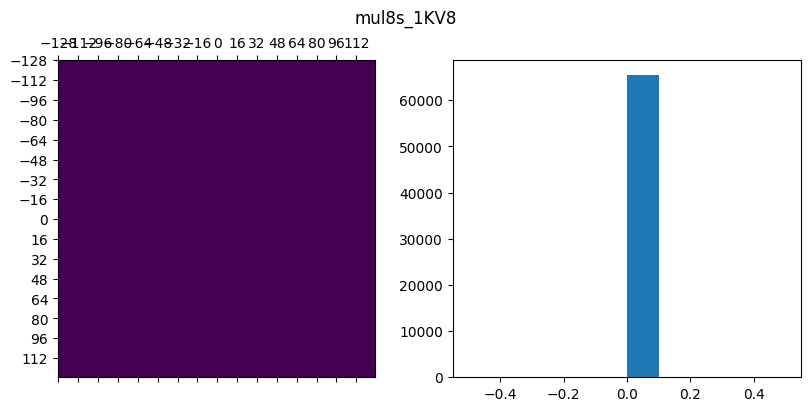

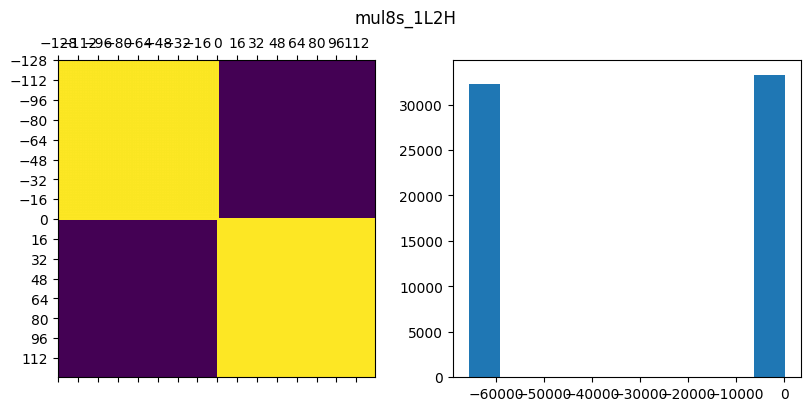

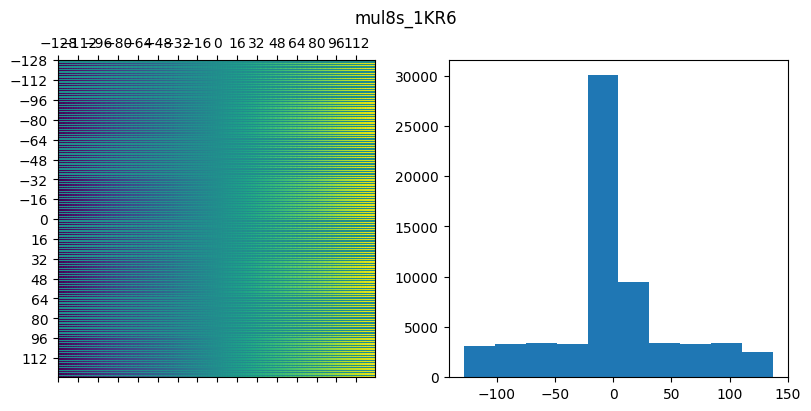

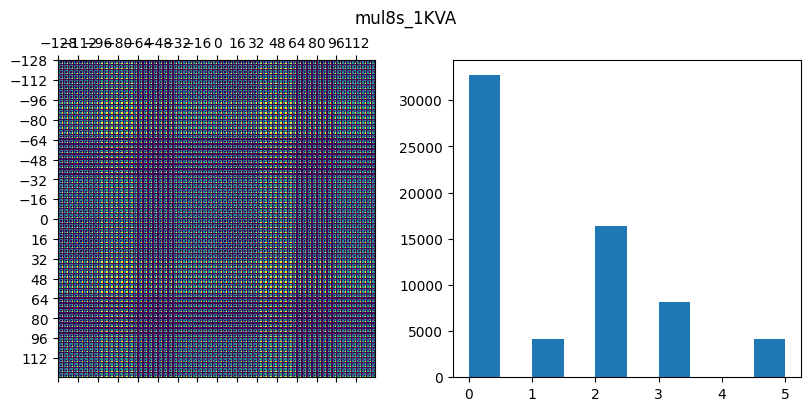

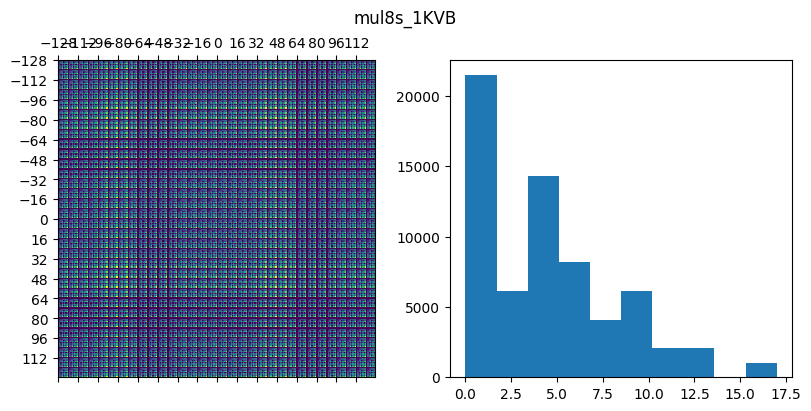

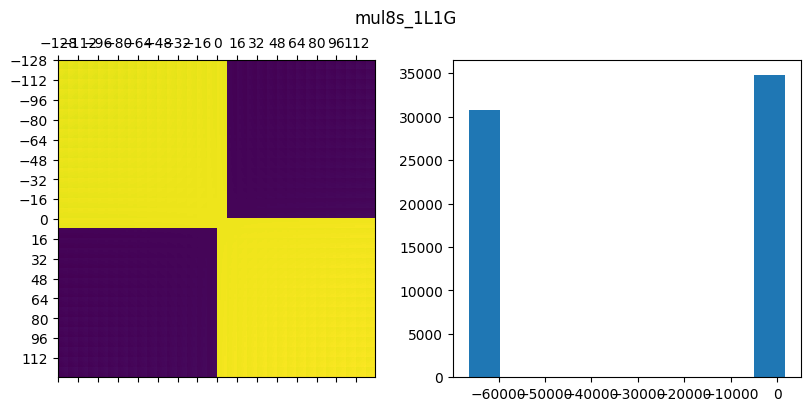

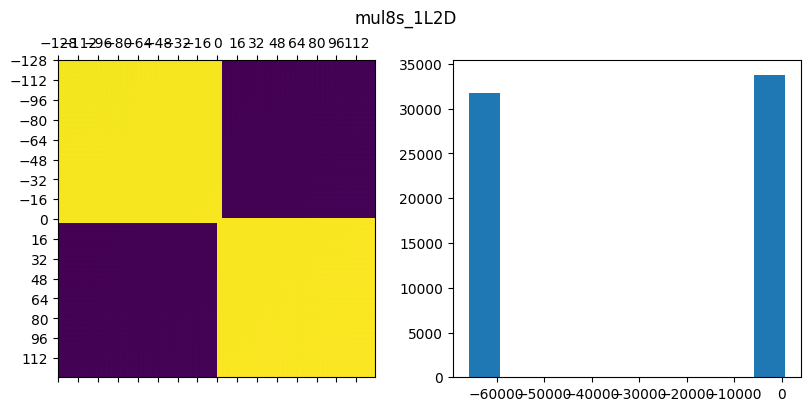

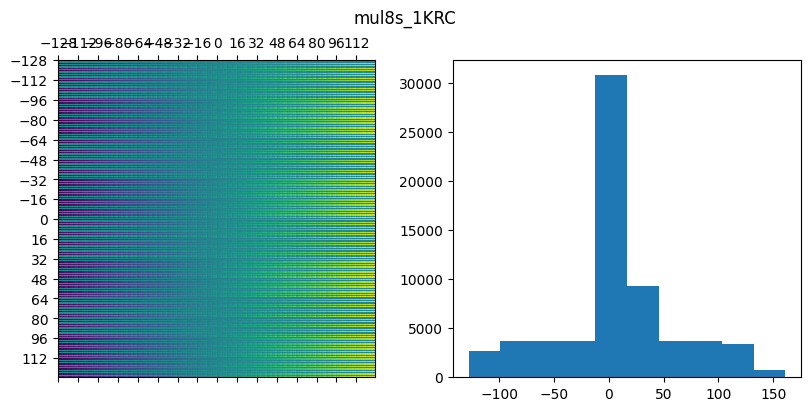

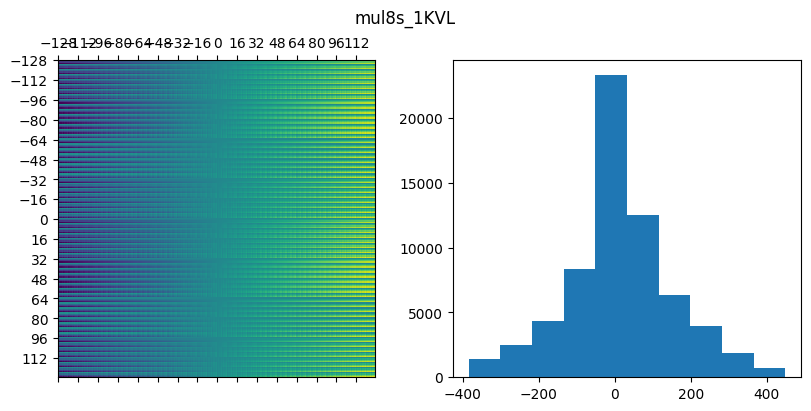

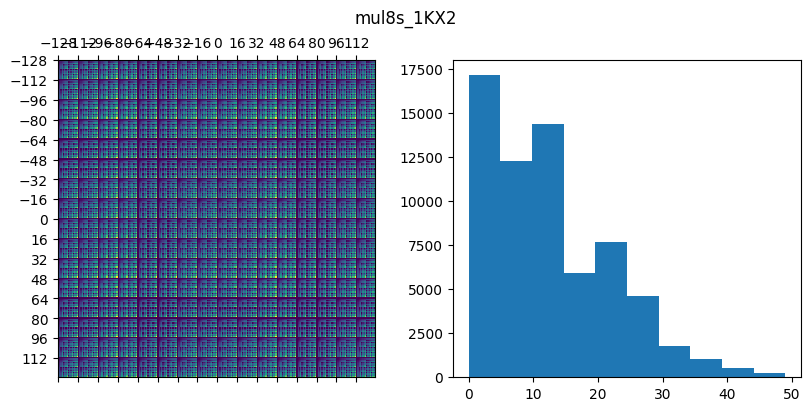

In [ ]:
import numpy as np
from matplotlib.ticker import MultipleLocator
from axcoperations import lcadd
import evoapproxlib as eal

axc_bits = 1 # Lower bits approximated
bits = 8
max_value = 2**bits // 2
i_range = np.arange(-max_value, max_value, dtype=np.int16)
j_range = np.arange(-max_value, max_value, dtype=np.int16)
exact_results = np.zeros((2**bits, 2**bits))
axc_results = np.zeros((2**bits, 2**bits))

for name, module in eal.multipliers['8x8_signed'].items():
    for i in i_range:
        for j in j_range:
            axc_mult = getattr(module, 'calc')
            #axc_results[i+max_value,j+max_value] = lcadd(i, j, axc_bits)
            axc_results[i+max_value,j+max_value] = axc_mult(i, j)
            exact_results[i+max_value,j+max_value] = i * j
            
    error = exact_results - axc_results
    minError = np.min(error)
    maxError = np.max(error)
    print(f"{name} {np.mean(error)} {np.median(error)}")

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")
    fig.suptitle(f"{name}")
    plot = axs[0].matshow(error, extent=(-max_value-0.5, max_value-0.5, max_value-0.5, -max_value-0.5))
    axs[0].xaxis.set_major_locator(MultipleLocator(max_value/8))
    axs[0].yaxis.set_major_locator(MultipleLocator(max_value/8))
    axs[1] = plt.hist(error.flatten())

## 12x12 signed

In [143]:
import ealwrapper as ealw

df = ealw.getMultipliersEAL('12x12_signed')
df = df.sort_values(by=['PDK45_PWR'], ascending=False)
df

,NAME,MAE_PERCENT,MAE,WCE_PERCENT,WCE,WCRE_PERCENT,EP_PERCENT,MRE_PERCENT,MSE,PDK45_PWR,PDK45_AREA,PDK45_DELAY
2,mul12s_2KL,0.000000,0.0,0.000000,0.0,0.0,0.00,0.00000,0.000000e+00,1.210,1650.5,2.33
3,mul12s_2KM,0.000001,0.2,0.000006,1.0,100.0,25.00,0.00047,2.000000e-01,1.205,1644.4,2.34
9,mul12s_2KN,0.000007,1.2,0.000030,5.0,500.0,50.00,0.00230,3.800000e+00,1.200,1631.8,2.32
10,mul12s_2KP,0.000025,4.2,0.000100,17.0,1700.0,68.75,0.00760,3.400000e+01,1.189,1605.9,2.32
11,mul12s_2KQ,0.000073,12.0,0.000290,49.0,4900.0,81.25,0.02100,2.480000e+02,1.168,1564.2,2.30
5,mul12s_2R1,0.003100,512.0,0.012000,2048.0,100.0,49.99,0.22000,6.990510e+05,1.093,1528.0,2.24
1,mul12s_2K0,0.003100,512.0,0.012000,2049.0,300.0,62.49,0.22000,6.990520e+05,1.091,1524.3,2.26
8,mul12s_2K5,0.003100,524.0,0.013000,2145.0,9700.0,90.61,0.25000,7.000700e+05,1.055,1443.6,2.22
6,mul12s_35J,0.005100,853.0,0.024000,4095.0,300.0,74.98,0.41000,1.398102e+06,0.965,1385.4,2.13
7,mul12s_2JL,0.009200,1540.0,0.037000,6209.0,6500.0,92.17,0.65000,4.893930e+06,0.948,1395.2,2.12


(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='MAE_PERCENT', ylabel='PDK45_PWR'>)

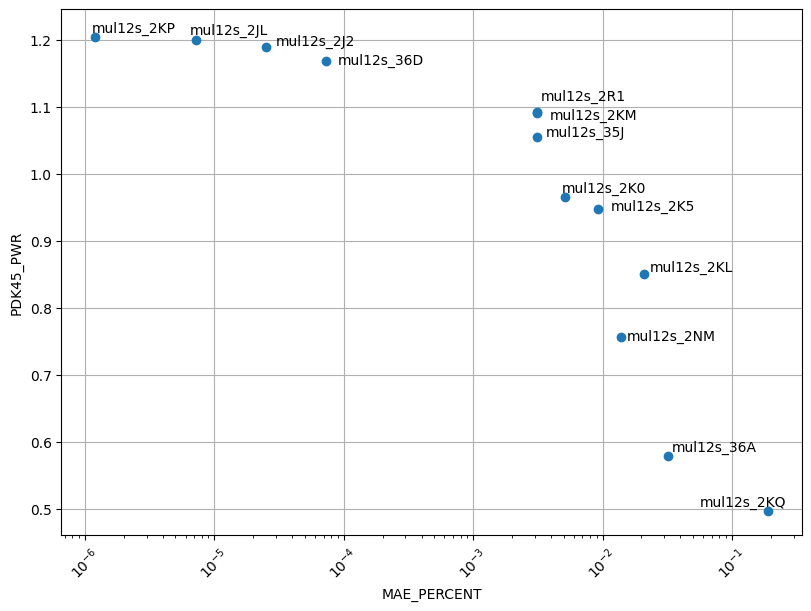

In [144]:
ealw.plotKPI(df, 'MAE_PERCENT', 'PDK45_PWR', log_x=True)
plt.title("12x12 signed")

## 16x16 signed

In [149]:
import ealwrapper as ealw

df = ealw.getMultipliersEAL('16x16_signed')
df = df.sort_values(by=['PDK45_PWR'], ascending=False)
df


,NAME,MAE_PERCENT,MAE,WCE_PERCENT,WCE,WCRE_PERCENT,EP_PERCENT,MRE_PERCENT,MSE,PDK45_PWR,PDK45_AREA,PDK45_DELAY
5,mul16s_HEB,0.00000,0.0,0.00000,0.0,0.0,0.00,0.000,0.000000e+00,2.400,2614.0,3.05
2,mul16s_G80,0.00019,8192.0,0.00076,32768.0,100.0,50.00,0.018,1.789570e+08,2.326,2764.2,3.09
1,mul16s_G7Z,0.00019,8192.0,0.00076,32769.0,300.0,62.50,0.018,1.789570e+08,2.325,2760.4,3.11
4,mul16s_HDG,0.00032,13653.0,0.00150,65535.0,300.0,75.00,0.034,3.579139e+08,2.130,2576.5,2.98
7,mul16s_GK2,0.00057,24580.0,0.00230,98369.0,6500.0,92.19,0.052,1.252699e+09,2.124,2640.3,2.95
0,mul16s_G7F,0.00130,57344.0,0.00530,229376.0,700.0,87.50,0.120,6.263494e+09,1.961,2495.7,2.87
8,mul16s_HHP,0.00089,38343.0,0.00460,196599.0,1500.0,93.75,0.098,2.505398e+09,1.775,2031.1,2.67
6,mul16s_HFZ,0.00200,87012.0,0.01100,458703.0,6300.0,98.43,0.220,1.252699e+10,1.483,1935.9,2.55
3,mul16s_GAT,0.01200,516096.0,0.04800,2064384.0,6300.0,98.44,1.060,4.772782e+11,1.396,1932.6,2.57


Text(0.5, 1.0, '16x16 signed')

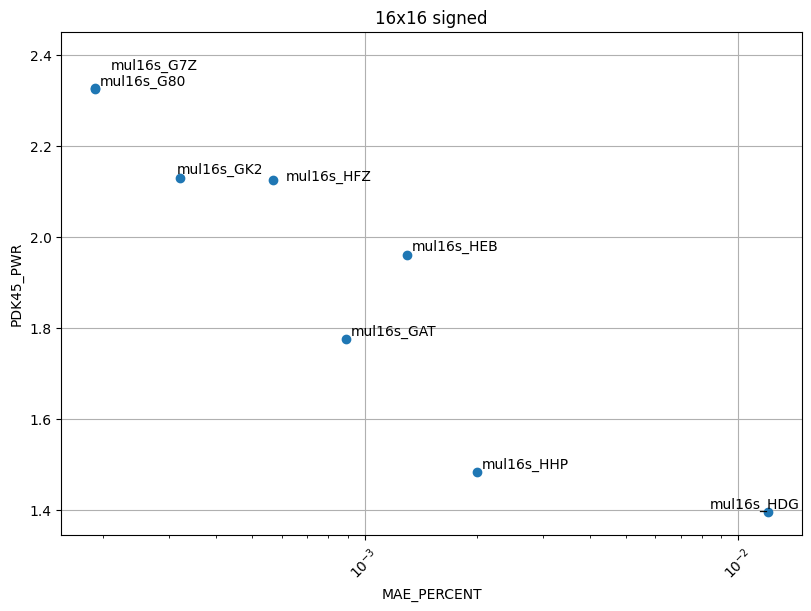

In [150]:
ealw.plotKPI(df, 'MAE_PERCENT', 'PDK45_PWR', log_x=True)
plt.title("16x16 signed")